# What is the infrared sky background?

Here we use the data from Oliva+ (2015) to compute the inter-line sky background.


In [1]:
import numpy as np
import os
%matplotlib inline
from pylab import *

import astropy
from astropy.table import Table
from astropy.convolution import convolve

rcParams["font.size"]=24

Read in the night sky spectrum from Oliva 2015

In [2]:
dat = np.loadtxt("data/Oliva2015/table4.dat")
ll,ss = dat.T

mosdat = np.loadtxt("data/Mosfire-sky-background/mosfire-130429.dat")
llm, ssm = mosdat.T
llm = (llm*1.62695+14500-1.62695)


Filter curves from MOSFIRE bandpass definitions

In [3]:
Y = "Y" ; J = "J" ; H = "H" 

filters = {Y: (.972, 1.124), J: (1.153, 1.352), H: (1.466, 1.807)}

# First order background level computation

In [4]:
RES = "RES" # Spectral resolution lambda/dl
LAMµ = "LAMµ" # Typical wavelength micron
Dtelm = "Dtelm" # Telescope area
Pixµ = "Pixµ" # pixel pitch in micron
FNO = "FNO" # Camera f/#
ETs = "ETs" # Exposure time in sec
SAMP = "SAMP" # pixels to sample a resolution element
RN = "RN" # Readnoise in e- after multiple samples
ETA = "ETA" # Efficiency fraction



def compute(sys):
    R = sys[RES]
    L = sys[LAMµ]
    D = sys[Dtelm]
    et = sys[ETs]
    smp = sys[SAMP]
    fno = sys[FNO]
    pp = sys[Pixµ]
    rn = sys[RN]
    eta = sys[ETA]
    
    
    A = 0.9 * np.pi*(D/2)**2
    
    pitch = D*fno/206265 * 1000000
    as2 = (pp/pitch)**2
    
    scale = pp*smp/pitch
    
    Omega = np.pi/(2*fno)**2
    A_pixel = pp**2
    GRASP = Omega * A_pixel
    
    BW = L/R
    
    shotnoise = np.sqrt(bgd * et * A * as2 * BW * eta)
    
    return [D, fno, pp, R, et, rn, np.round(scale,1), np.round(shotnoise,1), np.round(shotnoise/rn,1)]



bgd = 600 # photon / s / m2 / arcsec2 / micron
print("Background is %i versus the Maihara background of 600" % bgd)

sys1 = {RES: 3200, LAMµ: 1.65, Dtelm: 10, Pixµ: 18, FNO: 1.7, ETs: 120, SAMP: 3, RN: 5.5, ETA: 0.3}


rows = [compute(sys1)]

for fno in [1.0, 1.4, 1.6]:
    sys = {RES: 3200, LAMµ: 1.65, Dtelm: 6.5, Pixµ: 18, FNO: fno, ETs: 180, SAMP: 3, RN:5.5, ETA: 0.35}
    
    rows.append(compute(sys))
    
    
for fno in [1.0, 1.4, 1.6]:
    sys = {RES: 3200, LAMµ: 1.65, Dtelm: 6.5, Pixµ: 15, FNO: fno, ETs: 180, SAMP: 3, RN: 3, ETA:0.35}
    
    rows.append(compute(sys))


tab = Table(rows=rows, names=("D (m)", "f\/#", "pixel ($\mu$)", "$R$", "et (s)", "rn ($e^-$)", "scale ($as/res$)",  
                            "Shot noise ($e^-$)", "SN/RN"))


import sys
astropy.io.ascii.write(tab, sys.stdout, Writer=astropy.io.ascii.Latex)

tab

Background is 600 versus the Maihara background of 600
\begin{table}
\begin{tabular}{ccccccccc}
D (m) & f\/# & pixel ($\mu$) & $R$ & et (s) & rn ($e^-$) & scale ($as/res$) & Shot noise ($e^-$) & SN/RN \\
10.0 & 1.7 & 18 & 3200 & 120 & 5.5 & 0.7 & 6.1 & 1.1 \\
6.5 & 1.0 & 18 & 3200 & 180 & 5.5 & 1.7 & 13.8 & 2.5 \\
6.5 & 1.4 & 18 & 3200 & 180 & 5.5 & 1.2 & 9.8 & 1.8 \\
6.5 & 1.6 & 18 & 3200 & 180 & 5.5 & 1.1 & 8.6 & 1.6 \\
6.5 & 1.0 & 15 & 3200 & 180 & 3.0 & 1.4 & 11.5 & 3.8 \\
6.5 & 1.4 & 15 & 3200 & 180 & 3.0 & 1.0 & 8.2 & 2.7 \\
6.5 & 1.6 & 15 & 3200 & 180 & 3.0 & 0.9 & 7.2 & 2.4 \\
\end{tabular}
\end{table}


D (m),f\/#,pixel ($\mu$),$R$,et (s),rn ($e^-$),scale ($as/res$),Shot noise ($e^-$),SN/RN
float64,float64,int64,int64,int64,float64,float64,float64,float64
10.0,1.7,18,3200,120,5.5,0.7,6.1,1.1
6.5,1.0,18,3200,180,5.5,1.7,13.8,2.5
6.5,1.4,18,3200,180,5.5,1.2,9.8,1.8
6.5,1.6,18,3200,180,5.5,1.1,8.6,1.6
6.5,1.0,15,3200,180,3.0,1.4,11.5,3.8
6.5,1.4,15,3200,180,3.0,1.0,8.2,2.7
6.5,1.6,15,3200,180,3.0,0.9,7.2,2.4


<function matplotlib.pyplot.axvline>

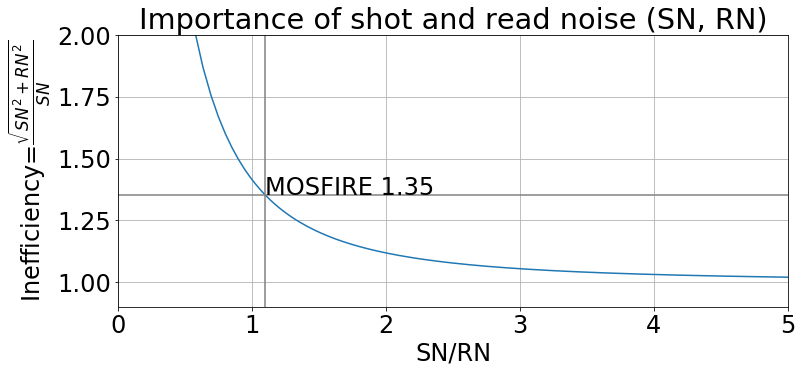

In [5]:
mos_sntorn = tab[0][8]
mos_sntorn

t = np.arange(1, 600)
RN = 5
s = 2
SN = np.sqrt(s*t)
x = SN/RN

num = np.argmin(np.abs(x-mos_sntorn))

figure(figsize=(12,5))
ineff = np.sqrt(SN**2 + RN**2)/SN
plot(x, ineff)

axvline(mos_sntorn, color='grey')
axhline(ineff[num], color='grey')
text(mos_sntorn, ineff[num], "MOSFIRE %1.2f" % ineff[num])

xlim(0.,5)
ylim(0,15)
grid(True)

title("Importance of shot and read noise (SN, RN)")
xlabel("SN/RN")
ylabel(r"Inefficiency=$\frac{\sqrt{SN^2+RN^2}}{SN}$")
ylim(.9,2)
axvline
#plot(t, np.sqrt(s*t))

#legend(["RN+SN", "SN"])

## Compare data table to Oliva's paper

Here I show that I can reproduce plots from the paper. I've pasted in Figure 3 from Oliva's paper below:

![alt text](fig3.png "Title")


And reproduce the first four panels.

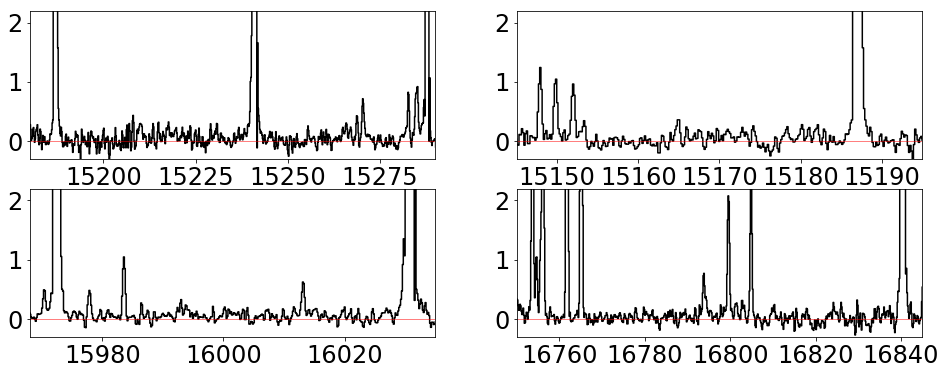

In [6]:
fig = figure(figsize=(16,6))

locs = [(15180, 15290), (15145, 15195), (15968, 16035), (16750, 16845)]

for ix, loc in enumerate(locs):
    subplot(2,2,ix+1)
    step(ll, ss, 'k')

    axhline(0, color='r', lw=.5)
    xlim(*loc)
    ylim(-.3,2.2)


## Observing code

Write the code that executes an "observation" of the GIANO spectrum

In [7]:
angs_to_mic = 1e4

def observe(spectrum, slit_width_pix=60, G_m2_as2=1, BW_angstrom=1, et_s=1, bgd_offset=200/angs_to_mic):
    """ observe spectrum [photon/s/Angstrom/m^2/arcsec^2]. 60 pix slit width is R~3800-4000 depending on 
    how to define resolution"""
    kernel = astropy.convolution.Box1DKernel(width=slit_width_pix)
    
    ss_smooth = convolve(spectrum, kernel) 
    observation = ss_smooth * G_m2_as2 * BW_angstrom * et_s + bgd_offset
    
    return observation 

In [8]:
observe(ss)

array([0.1855    , 0.19057083, 0.194225  , ..., 0.05836333, 0.05895583,
       0.06031667])

# Now convolve down the spectrum - Compare MOSFIRE to GIANO

Here I take a spectrum from MOSFIRE in 2013 and compare it to the GIANO results. The end result is that qualitatively the two look similar. Down at 0 flux, the MOSFIRE results depart quite substantially from the GIANO results; but, I made no effort to really nail the zero point of the MOSFIRE spectra (nor can I). So, I trust the GIANO results more.

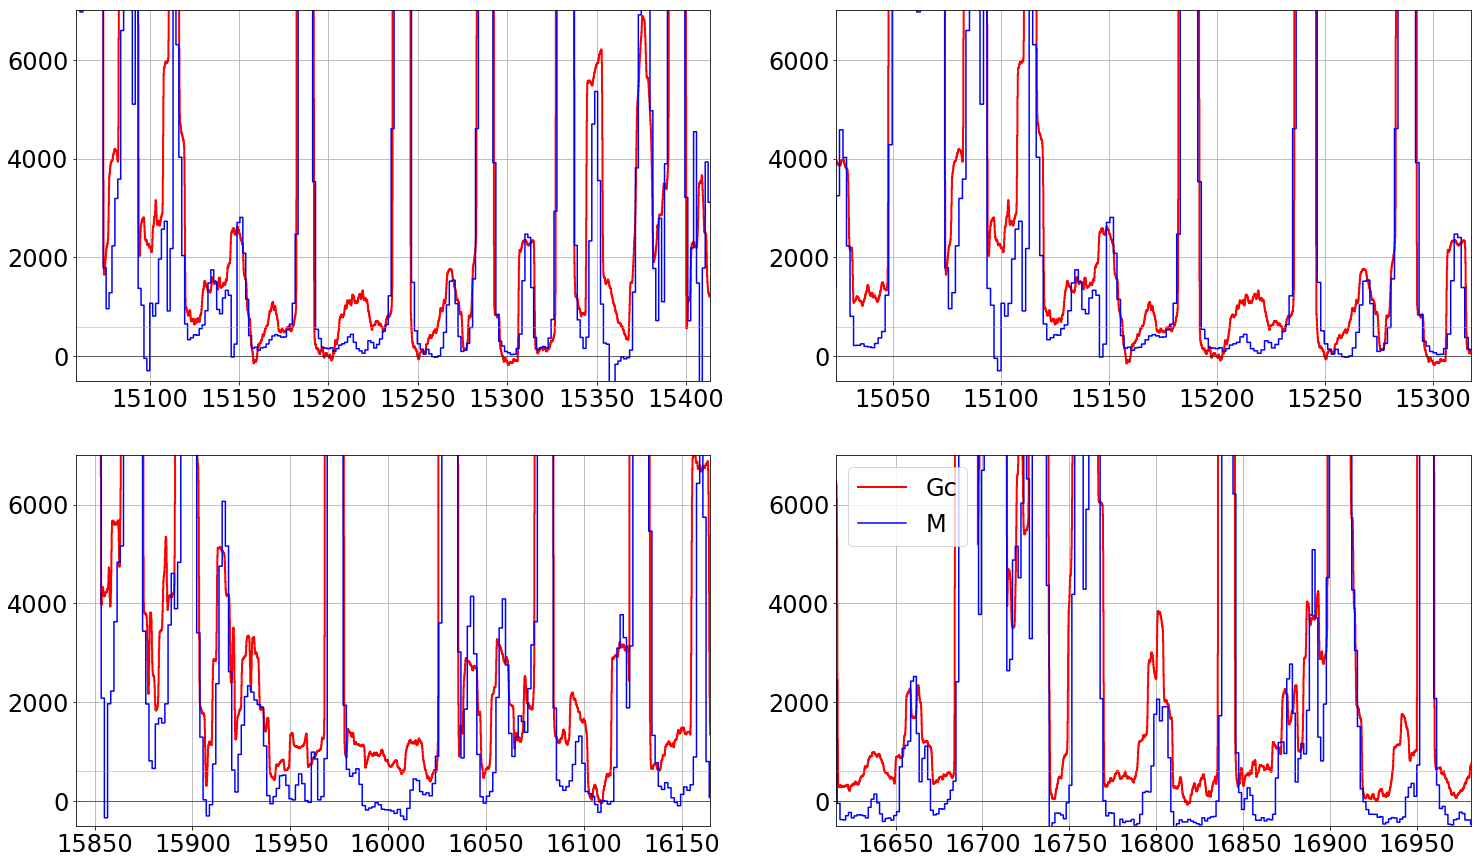

In [9]:
fig = figure(figsize=(25,15))

ss_smooth = observe(ss)

locs = [(15180, 15290), (15145, 15195), (15968, 16035), (16750, 16845)]

F = .992
zpt = np.percentile(ssm,25)

for ix, loc in enumerate(locs):
    subplot(2,2,ix+1)
    #step(ll, ss*angs_to_mic/10, 'k', lw=1)
    step(ll, ss_smooth*angs_to_mic, 'r', lw=2)
    step(llm+16, (ssm-zpt)*13, 'b')

    axhline(0, color='k', lw=.5)
    axhline(600, color='y', lw=.5)
    
    xlim(loc[0]*F, loc[1]/F)
    ylim(-500,7000)
    grid(True)

legend(["Gc", "M"])



Note in the figure above the zero-point of the MOSFIRE spectra (Blue) don't match the zero-point of GIANO well (red); however, very little care was taken to zeropoint the MOSFIRE spectra, so I tend to trust the GIANO results.

# Boost background to 300 

The GIANO paper indicates that they think the signal level in the H band is about 300 photon / s / m2 / micron bandwidth / arcsec2, so I add a little bit of signal to the GIANO results to recover this result. 

Almost all the uncertainty of this analysis comes from this step. The `observe` routine includes this added background.


(-100, 800)

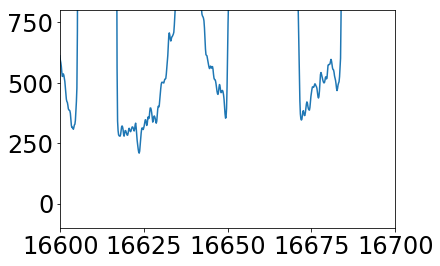

In [10]:
GIANO_spec = observe(ss)

plot(ll, GIANO_spec*angs_to_mic)


xlim(16610-10, 16690+10)
ylim(-100, 800)

# Now look at background limit

I define background limit as shot noise is 2x the read noise. This way the read noise amounts to about 25% of the total noise.

In [11]:
RN = 5.8 # For MOSFIRE, seems reasonable for H2RGs with 16 Fowler samples
Goal = (1.5*RN)**2
print("For a read noise of %s the desired sky shot noise is %2.1f and signal of %i photon" % (RN, 2*RN, Goal))

For a read noise of 5.8 the desired sky shot noise is 11.6 and signal of 75 photon


In [12]:
# Bandwidth
sampling_pix = 2.5 # pixels per slit width
R = 3700

BW_pix = 15200/R/sampling_pix

# Magellan
Dtel = 6.5
Atel = np.pi*(Dtel/2)**2 - np.pi*(Dtel*.25/2)**2
Omega = 0.25**2
Gs = {"Magellan": Atel * Omega}

# Mosfire
Dtel = 10
Atel = np.pi*(Dtel/2)**2 - np.pi*(Dtel*.25/2)**2
Omega = 0.18**2 * 1.4
Gs["MOSFIRE"] = Atel * Omega




print("Gs")
print(" MOSFIRE: %2.1f" % Gs["MOSFIRE"])
print("Magellan: %2.1f" % Gs["Magellan"])


Gs
 MOSFIRE: 3.3
Magellan: 1.9


NameError: name 'BW' is not defined

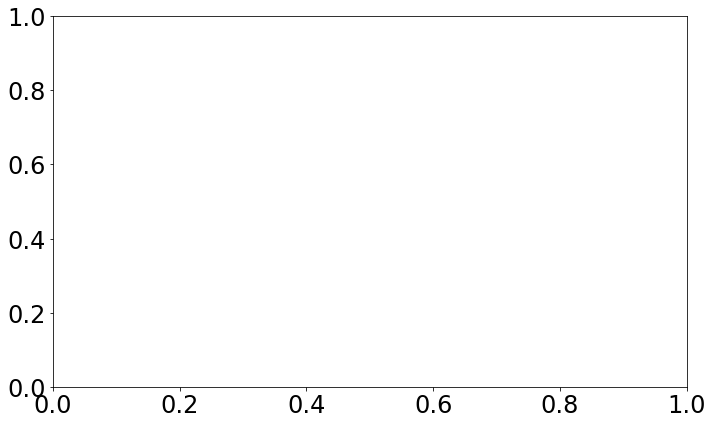

In [13]:

angs_to_mic = 1e4
locs = [(15180, 15290), (15145, 15195), (15968, 16035), (16750, 16845)]

F = .992
zpt = np.percentile(ssm,25)


for tel, G in Gs.items():

    fig = figure(figsize=(25,15))
    for ix, loc in enumerate(locs):
        subplot(2,2,ix+1)
        res = observe(ss, slit_width_pix=60, BW_angstrom=BW, G_m2_as2=G)
        step(ll, res, 'k', lw=2)

        xlim(loc[0]*F, loc[1]/F)
        ylim(-.5, 5)
        title(tel)

        axhline(Goal/120, color='r')
        axhline(Goal/600, color='b')
        grid(True)

        if (ix % 2) == 0:
            ylabel("$\gamma$/s")

legend(["Spectrum", "2 min", "10 min"])


# H band fraction that is background limited

In [14]:
def fraction_above_thresh(vec, thresh):
    """ Returns the fraction of pixels in `vec` that are above threshold `thresh`"""
    
    n_above = len(np.where(sp > thresh)[0])
    N = len(vec)
    
    return n_above/N
    

Most of the action happens in the cell below:

In [15]:

Girmos = Gs["Magellan"]
Gmosfire = Gs["MOSFIRE"]

ets = np.linspace(1,1000,50)
resirmos = np.zeros_like(ets)
resmosfire = np.zeros_like(ets)

# Goal is 1.5 x higher than the read noise
Goal = (1.5*RN)**2

for ix,et in enumerate(ets):
    sp = observe(ss, BW_angstrom=BW, G_m2_as2=Girmos, et_s=et, slit_width_pix=60)
    resirmos[ix] = fraction_above_thresh(sp, Goal)

    sp = observe(ss, BW_angstrom=BW, G_m2_as2=Gmosfire, et_s=et, slit_width_pix=60)
    resmosfire[ix] = fraction_above_thresh(sp, Goal)

NameError: name 'BW' is not defined

### Now plot it all up

/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


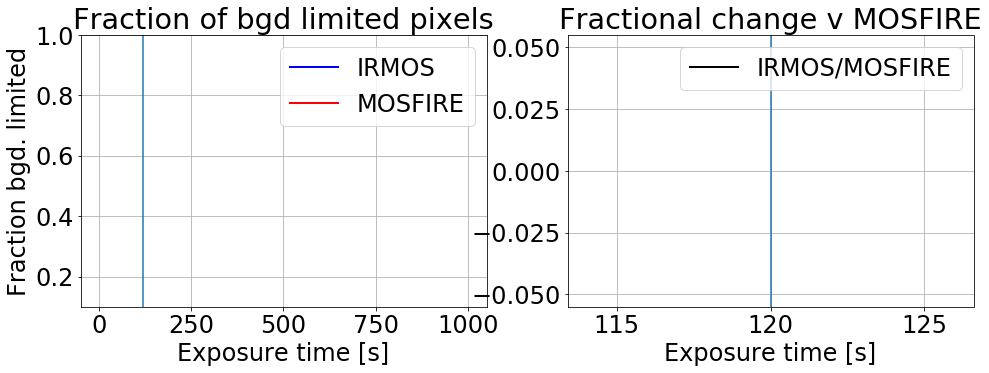

In [16]:
figure(figsize=(16,5))

subplot(1,2,1)
plot(ets,resirmos, 'b', lw=2)
plot(ets,resmosfire, 'r', lw=2)
ylim(0.1,1)
grid(True)
xlabel("Exposure time [s]")
ylabel("Fraction bgd. limited")

legend(["IRMOS", "MOSFIRE"])
title("Fraction of bgd limited pixels")
axvline(120)

subplot(1,2,2)
title("Fractional change v MOSFIRE")
plot(ets, resirmos/resmosfire-1, 'k-', lw=2)
axvline(120)
xlabel("Exposure time [s]")

legend(["IRMOS/MOSFIRE"])
grid(True)